# Spam Classification

The objective of it is to generate a model capable to classify a email as spam or not spam.

The dataset used was from http://www2.aueb.gr/users/ion/data/enron-spam/

## Imports

In [1]:
import pandas as pd
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text as txt
import string
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from textblob import TextBlob
import email
from email.message import EmailMessage
from email.parser import BytesParser, Parser
from email.policy import default
import ast
import re

[nltk_data] Downloading package stopwords to /home/phrc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/phrc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Functions

In [31]:
def createDf(path):
    """
    Read all email files and convert to a dataframe

    Parameters
    ----------
    path: str
        Path to a root directory to be read

    Returns
    ----------
    dataframe
        a dataframe with x columns based in all emails properties
    """
    os.chdir(path)
    data = []
    for root, dirs, files in os.walk(path):
         for file in files:
            with open(os.path.join(root, file), "rb") as openFile:
                dictTemp = {}
                try:
                    message = email.message_from_binary_file(openFile, policy=default)
                    #Parser(policy=default).parsestr(openFile.read())
                    dictTemp['file'] = openFile.name
                    for key in message.keys():
                        dictTemp[key.lower()] = message[key]
                    dictTemp['messageType'] = message.get_content_type()
                    body = message.get_body()
                    if body['content-type'].maintype == 'text':
                        if body['content-type'].subtype == 'plain':
                            dictTemp['messageStr'] = str(body.get_content())
                        elif body['content-type'].subtype == 'html':
                            dictTemp['messageStr'] = str(body)
                    elif body['content-type'].content_type in 'multipart':
                        dictTemp['messageStr'] = str(body.get_body(preferencelist=('html')))
                    dictTemp['parseError'] = False                 
                except:
                    dictTemp['parseError'] = True
                data.append(dictTemp)
    df = pd.DataFrame(data)
    return df

def emailTextCleanner(text):
    """
    Remove:
        Html Tags
        Email headers
        Ponctuation
        break lines and tabs
    
    And convert the string to lower case 

    Parameters
    ----------
    text: str

    Returns
    ----------
    str
    """
    try:
        text = str(text).lower()
        clean = re.compile('charset.*\n')
        text = re.sub(clean, '', text)
        clean = re.compile('content-.*\n')
        text = re.sub(clean, '', text)
        clean = re.compile('received: from.*\n')
        text = re.sub(clean, '', text)
        text = text.replace('\n', ' ')
        text = text.replace('\t', ' ')
        clean = re.compile('<.*?>')
        text = re.sub(clean, '', str(text))
        clean = re.compile('['+string.punctuation+']')
        text = re.sub(clean, ' ', text)
        clean = re.compile("[0-9]")
        text = re.sub(clean, " ", text)
        toRemove = frozenset(['xpriority','nbsp', 'enron','xmsmailpriority','xmimeole','mimeole','cc','enrons'])
        pattern = re.compile(r'\b(' + r'|'.join(toRemove) + r')\b\s*')
        text = pattern.sub(' ', text)


        return text
    except:
        print(type(text))
        return ""
#    text = text.replace('Subject:', '', 1)
    #print(text)
    #print("---------------------------------------------")
    #print("---------------------------------------------")
    #text = TextBlob(text)
    #text = str(text.correct())
    #print(text)
    #print("\n")
#    return text

def lemmatizeList(words):
    """
    Lemmatize a list of string

    Parameters
    ----------
    words: list of str

    Returns
    ----------
    list of str
    """
#    print("|", end='')
    lem = WordNetLemmatizer()
    for i in range(len(words)):
#        text = TextBlob(words[i])
#        words[i] = str(text.correct())
        words[i] = lem.lemmatize(words[i], 'v')
        words[i] = lem.lemmatize(words[i], 'n')
    return words

def revomeWordsWithOneCharacter(words):
    return list(filter(lambda x : len(x) > 1, words))

def removeDigits(words):
    return list(filter(lambda x : x.isdigit() == False, words))

## Dataset generation

In [3]:
root = '/home/phrc/Python Project/Spam Email Classifier/'
#root2 = '/Users/phrc/Documents/Projects/pythonProject/SpamEmailClassifier/'

spamPath = root+'emails/spam/'
hamPath = root+'emails/ham/'


dfSpam = createDf(spamPath)
dfHam = createDf(hamPath)

## Dataset Size

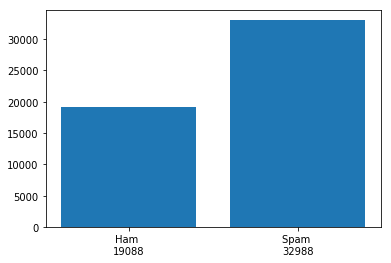

In [4]:

plt.bar(np.arange(2), (len(dfHam), len(dfSpam)), align='center')
plt.xticks(np.arange(2), ('Ham \n{}'.format(len(dfHam)), 'Spam \n{}'.format(len(dfSpam))))

plt.show();

In [5]:
dfSpam.head()

,0x-accept-language,1,2,accreditor,alternate-recipient,andorra-islamabad,approved,approved-by,archenemy-matthew,auto-forwarded,...,x-yahoo-newman-property,x-yahoo-profile,x-yoursite-mailscanner,x-yoursite-mailscanner-information,x-zinester-pid,x_id,x_uid,xid4,xmailing-id,xref
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Dataset Spam Columns Analyse

In [6]:
dfSpamDesc = dfSpam.describe(include=['object']).T
n = len(dfSpam) * 0.75 
dfSpamDesc[dfSpamDesc['count'] > n].head(300)

,count,unique,top,freq
content-type,32835,7616,"text/html; charset=""iso-8859-7""",12553
date,32572,30490,"Tue, 19 Jan 2038 11:14:07 +0800",52
file,32988,32988,/home/phrc/Python Project/Spam Email Classifie...,1
from,32957,27895,COMPUTRON <khatun@emirates.net.ae>,347
messageStr,29849,27602,Call out Gouranga be happy!!!\nGouranga Gouran...,79
messageType,32965,8,text/html,16715
mime-version,31915,448,1.0,30943
subject,32831,20625,,613
to,32380,5254,paliourg@iit.demokritos.gr,7068


### Dataset Ham Columns Analyse

In [7]:
dfHamDesc = dfHam.describe(include=['object']).T
n = len(dfHam) * 0.75 
dfHamDesc[dfHamDesc['count']> 15000].head(300)

,count,unique,top,freq
content-transfer-encoding,19079,2,7bit,18363
content-type,19079,2,"text/plain; charset=""us-ascii""",17818
date,19088,18173,"Wed, 13 Dec 2000 04:41:00 -0800",5
file,19088,19088,/home/phrc/Python Project/Spam Email Classifie...,1
from,19088,2349,pete.davis@enron.com,1395
message-id,19088,19088,<32480778.1075840893913.JavaMail.evans@thyme>,1
messageStr,19079,18401,\n\nTammie Schoppe\nEnron Americas-Office of ...,5
messageType,19079,1,text/plain,19079
mime-version,19079,1,1.0,19079
subject,19084,14679,Schedule Crawler: HourAhead Failure,343


### Removing unnescessary columns

In [8]:
dfSpam = dfSpam[['content-type', 'date', 'from', 'messageStr', 'messageType', 'subject', 'to', 'parseError', 'file']]
dfHam = dfHam[['content-type', 'date', 'from', 'messageStr', 'messageType', 'subject', 'to', 'parseError', 'file']]


### Emails with Parser Error 

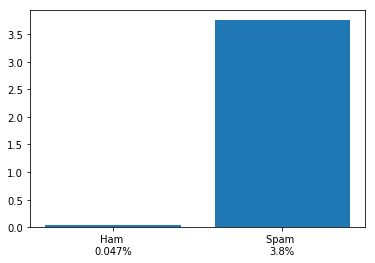

In [9]:
dfHamP = dfHam[dfHam['parseError'] == True]
dfSpamP = dfSpam[dfSpam['parseError'] == True]
hamFreq = (len(dfHamP) * 100 / len(dfHam))
spamFreq = (len(dfSpamP) * 100 / len(dfSpam))
plt.bar(np.arange(2), (hamFreq, spamFreq), align='center')
plt.xticks(np.arange(2), ('Ham \n{0:.2}%'.format(hamFreq), 'Spam \n{0:.2}%'.format(spamFreq)))

plt.show();

### Removing emails with parser problems 

In [10]:
dfSpam = dfSpam[dfSpam['parseError'] == False]
dfHam = dfHam[dfHam['parseError'] == False]

del dfHam['parseError']
del dfSpam['parseError']

### Join datasets

In [11]:
dfSpam['isSpam'] = True
dfHam['isSpam'] = False

print(dfHam.columns.values)
print(dfSpam.columns.values)

dfMaster = pd.concat([dfSpam, dfHam])
print(len(dfMaster))
dfMaster.head()

['content-type' 'date' 'from' 'messageStr' 'messageType' 'subject' 'to'
 'file' 'isSpam']
['content-type' 'date' 'from' 'messageStr' 'messageType' 'subject' 'to'
 'file' 'isSpam']
50828


,content-type,date,from,messageStr,messageType,subject,to,file,isSpam
0,"text/plain; charset=""US-ASCII""","Fri, 24 Jun 2005 23:29:50 +0600",Semen Analysis <ezcnppih@rogers.com>,"""My girlfriend and me have been really enjoyin...",text/plain,squirts like a fountain,projecthoneypot@projecthoneypot.org,/home/phrc/Python Project/Spam Email Classifie...,True
1,"multipart/alternative; boundary=""=_NextPart_2r...","Fri, 24 Jun 2005 06:36:39 -0500",GoTo My Meeting <meeting@zoolant.com>,Content-Type: text/html\nContent-Transfer-Enco...,multipart/alternative,The next generation in online meetings!,projecthoneypot@projecthoneypot.org,/home/phrc/Python Project/Spam Email Classifie...,True
3,"multipart/alternative; boundary=""--10202231489...","Wed, 13 Jul 2005 09:06:59 -0400",Donovan Wilson <KHTIQA@yahoo.com>,Content-Type: text/html;\nContent-Transfer-Enc...,multipart/alternative,"New challenges! [ref:438] Wed, 13 Ju...",projecthoneypot@projecthoneypot.org,/home/phrc/Python Project/Spam Email Classifie...,True
4,"text/html; charset=""iso-8859-1""","Sun, 03 Jul 2005 21:45:26 +0000",Olene Nash <assisneto2003@nteu35.org>,Received: from unknown (HELO @matrixmailserver...,text/html,Save your money buy getting this thing here,projecthoneypot@projecthoneypot.org,/home/phrc/Python Project/Spam Email Classifie...,True
5,"multipart/alternative; boundary=""--""","Wed, 22 Jun 2005 05:57:20 -0500",Barclays Bank PLC <account@Barclays.co.uk>,\n\n,multipart/alternative,"Important Notice: June 22, 2005",projecthoneypot@projecthoneypot.org,/home/phrc/Python Project/Spam Email Classifie...,True


### Check email message and email type 

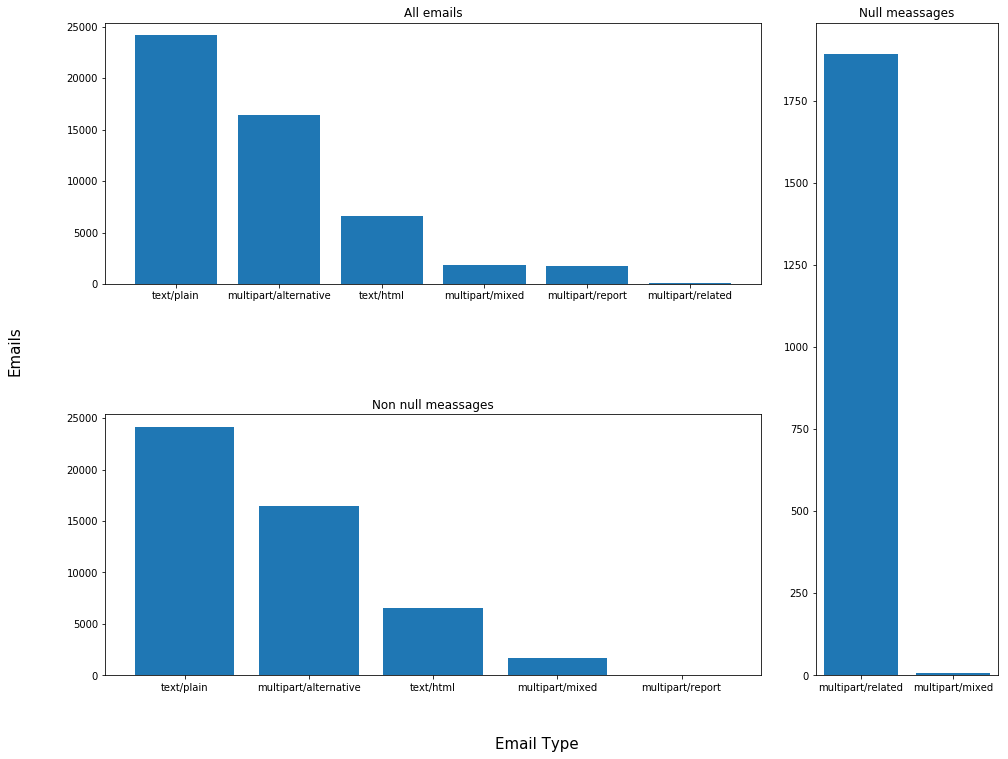

In [12]:
fig = plt.figure(figsize = (16,12))
grid = plt.GridSpec(2,4, wspace =0.3, hspace =0.5)
barAll = fig.add_subplot(grid[0,0:3])
barNonNull = fig.add_subplot(grid[1,0:3])
barNull = fig.add_subplot(grid[0:2,3])

barAll.bar(
    dfMaster['messageType'].unique(), 
    dfMaster['messageType'].value_counts(), 
    align='center'
)
barAll.set_title('All emails')

barNonNull.bar(
    dfMaster[dfMaster['messageStr'].notnull()]['messageType'].unique(), 
    dfMaster[dfMaster['messageStr'].notnull()]['messageType'].value_counts(), 
    align='center'
)

barNonNull.set_title('Non null meassages')

barNull.bar(
    dfMaster[dfMaster['messageStr'].isnull()]['messageType'].unique(), 
    dfMaster[dfMaster['messageStr'].isnull()]['messageType'].value_counts(), 
    align='center'
)

barNull.set_title('Null meassages')

fig.text(0.5, 0.04, 'Email Type', ha='center', fontsize=15)
fig.text(0.04, 0.5, 'Emails', va='center', rotation='vertical', fontsize=15)

plt.show()

### Null messages proportions

([<matplotlib.patches.Wedge at 0x7f7021d28748>,
 [Text(-1.1917347975584003, 0.1405993324608573, 'Non Null'),
  Text(1.1917347876855027, -0.14059941614455557, 'Null')],
 [Text(-0.49655616564933347, 0.05858305519202387, '96%'),
  Text(0.4965561615356261, -0.05858309006023149, '4%')])

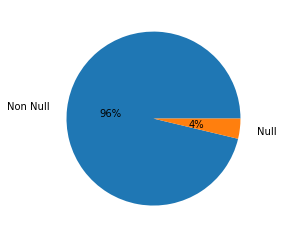

In [13]:
plt.pie([len(dfMaster[dfMaster['messageStr'].notnull()]), len(dfMaster[dfMaster['messageStr'].isnull()])], 
        labels=['Non Null', 'Null'], autopct='%1.0f%%', pctdistance=0.5, labeldistance=1.2)


### Remove null messages 

In [14]:
dfMaster = dfMaster[dfMaster['messageStr'].notnull()]
print(len(dfMaster[dfMaster['messageStr'].isnull()]))

0


### Remove HTML tags from the messages 

In [15]:
dfMaster['treatedMessage'] = dfMaster['messageStr'].apply(emailTextCleanner)


dfMaster.head()


,content-type,date,from,messageStr,messageType,subject,to,file,isSpam,treatedMessage
0,"text/plain; charset=""US-ASCII""","Fri, 24 Jun 2005 23:29:50 +0600",Semen Analysis <ezcnppih@rogers.com>,"""My girlfriend and me have been really enjoyin...",text/plain,squirts like a fountain,projecthoneypot@projecthoneypot.org,/home/phrc/Python Project/Spam Email Classifie...,True,girlfriend really enjoying making hom...
1,"multipart/alternative; boundary=""=_NextPart_2r...","Fri, 24 Jun 2005 06:36:39 -0500",GoTo My Meeting <meeting@zoolant.com>,Content-Type: text/html\nContent-Transfer-Enco...,multipart/alternative,The next generation in online meetings!,projecthoneypot@projecthoneypot.org,/home/phrc/Python Project/Spam Email Classifie...,True,gotomeeting generation...
3,"multipart/alternative; boundary=""--10202231489...","Wed, 13 Jul 2005 09:06:59 -0400",Donovan Wilson <KHTIQA@yahoo.com>,Content-Type: text/html;\nContent-Transfer-Enc...,multipart/alternative,"New challenges! [ref:438] Wed, 13 Ju...",projecthoneypot@projecthoneypot.org,/home/phrc/Python Project/Spam Email Classifie...,True,...
4,"text/html; charset=""iso-8859-1""","Sun, 03 Jul 2005 21:45:26 +0000",Olene Nash <assisneto2003@nteu35.org>,Received: from unknown (HELO @matrixmailserver...,text/html,Save your money buy getting this thing here,projecthoneypot@projecthoneypot.org,/home/phrc/Python Project/Spam Email Classifie...,True,projecthoneypotmailserver smtp jul ...
5,"multipart/alternative; boundary=""--""","Wed, 22 Jun 2005 05:57:20 -0500",Barclays Bank PLC <account@Barclays.co.uk>,\n\n,multipart/alternative,"Important Notice: June 22, 2005",projecthoneypot@projecthoneypot.org,/home/phrc/Python Project/Spam Email Classifie...,True,


In [17]:
#del dfMaster['wordsList']

dfMaster.describe(include=['object']).T.head(100)


,count,unique,top,freq
content-type,48928,5361,"text/plain; charset=""us-ascii""",19439
date,48633,46024,"Tue, 19 Jan 2038 11:14:07 +0800",52
from,48925,27347,pete.davis@enron.com,1395
messageStr,48928,46003,Call out Gouranga be happy!!!\nGouranga Gouran...,79
messageType,48928,5,text/plain,24154
subject,48804,33922,,883
to,47699,10307,paliourg@iit.demokritos.gr,7035
file,48928,48928,/home/phrc/Python Project/Spam Email Classifie...,1
treatedMessage,48928,41699,start date hourahead hour ...,205


In [18]:
dfTemp = dfMaster[dfMaster['messageType'].str.contains('multipart')]
len(dfTemp)


8343

In [19]:
dfTemp.head(30)

,content-type,date,from,messageStr,messageType,subject,to,file,isSpam,treatedMessage
1,"multipart/alternative; boundary=""=_NextPart_2r...","Fri, 24 Jun 2005 06:36:39 -0500",GoTo My Meeting <meeting@zoolant.com>,Content-Type: text/html\nContent-Transfer-Enco...,multipart/alternative,The next generation in online meetings!,projecthoneypot@projecthoneypot.org,/home/phrc/Python Project/Spam Email Classifie...,True,gotomeeting generation...
3,"multipart/alternative; boundary=""--10202231489...","Wed, 13 Jul 2005 09:06:59 -0400",Donovan Wilson <KHTIQA@yahoo.com>,Content-Type: text/html;\nContent-Transfer-Enc...,multipart/alternative,"New challenges! [ref:438] Wed, 13 Ju...",projecthoneypot@projecthoneypot.org,/home/phrc/Python Project/Spam Email Classifie...,True,...
5,"multipart/alternative; boundary=""--""","Wed, 22 Jun 2005 05:57:20 -0500",Barclays Bank PLC <account@Barclays.co.uk>,\n\n,multipart/alternative,"Important Notice: June 22, 2005",projecthoneypot@projecthoneypot.org,/home/phrc/Python Project/Spam Email Classifie...,True,
6,"multipart/mixed; boundary=""----=_NextPart_000_...","Fri, 01 Jul 2005 23:39:00 +0000",xoxo santa cruz <xoxocomunica@hotmail.com>,\n\n__________________________________________...,multipart/mixed,boletín DIF,projecthoneypot@projecthoneypot.org,/home/phrc/Python Project/Spam Email Classifie...,True,...
7,"multipart/alternative; boundary=""----=_NextPar...","Thu, 23 Jun 2005 15:40:32 -0500",Zainab Holt <HoltZainab_8304@gamerscentral.com>,"Content-Type: text/html;\n\tcharset=""us-ascii""...",multipart/alternative,Savee over 70% on your medz,Ormonde Koch <projecthoneypot@projecthoneypot....,/home/phrc/Python Project/Spam Email Classifie...,True,hello welcome pharmonl rainfall ine...
8,"multipart/report; report-type=""delivery-status...","Tue, 19 Jul 2005 12:56:32 +0200",amavisd-new <postmaster@mx1.b-one.net>,Your message to:\n-> felskickat@snillet.com\n\...,multipart/report,Considered UNSOLICITED BULK EMAIL from you,projecthoneypot@projecthoneypot.org,/home/phrc/Python Project/Spam Email Classifie...,True,message felskickat snillet com considered ...
9,"multipart/alternative; boundary=""=_NextPart_2r...","Wed, 22 Jun 2005 09:09:07 -0500",Burn the Fat <burnfat@zoolant.com>,Content-Type: text/html\nContent-Transfer-Enco...,multipart/alternative,Loose Weight Fast Guaranteed.,projecthoneypot@projecthoneypot.org,/home/phrc/Python Project/Spam Email Classifie...,True,outlaw bodybuilder reveals fa...
10,"multipart/alternative; boundary=""=_NextPart_2r...","Wed, 20 Jul 2005 16:45:54 +0800",jammewu@yahoo.com.cn,Content-Type: text/html\nContent-Transfer-Enco...,multipart/alternative,RE:your inquired,projecthoneypot@projecthoneypot.org,/home/phrc/Python Project/Spam Email Classifie...,True,home dear sir madam understand...
14,"multipart/mixed; boundary=""-----=963_7963_0K64...","Tue, 19 Jul 2005 03:51:51 +0100",christopher Dituri <2quick4u@racingmail.com>,Content-Type: text/html;\nContent-Transfer-Enc...,multipart/mixed,terror in London,projecthoneypot@projecthoneypot.org,/home/phrc/Python Project/Spam Email Classifie...,True,mercy adv...
15,"multipart/alternative; boundary=""=_NextPart_2r...","Thu, 30 Jun 2005 10:43:11 -0500","""F>ree Gadgets"" <gadgets@zoolant.com>",Content-Type: text/html\nContent-Transfer-Enco...,multipart/alternative,F>ree Gadgets for everyone!,projecthoneypot@projecthoneypot.org,/home/phrc/Python Project/Spam Email Classifie...,True,f gt ree gadgets ...


## Preparing the dataset

In [20]:
#Create a column with list of words
dfMaster['wordsList'] = dfMaster['treatedMessage'].str.split().apply(lemmatizeList).apply(revomeWordsWithOneCharacter)



#Create a columns to calculate the total amount of words
dfMaster['totalTreatedWords'] = dfMaster['wordsList'].apply(lambda x : len(x))
dfMaster['treatedTextLen'] = dfMaster['treatedMessage'].apply(lambda x : len(x))
dfMaster['textLen'] = dfMaster['messageStr'].apply(lambda x : len(str(x)))
dfMaster['uniqueWordsLen'] = dfMaster['wordsList'].apply(lambda x : len(set(x)))

dfMaster.head()

,content-type,date,from,messageStr,messageType,subject,to,file,isSpam,treatedMessage,wordsList,totalTreatedWords,treatedTextLen,textLen,uniqueWordsLen
0,"text/plain; charset=""US-ASCII""","Fri, 24 Jun 2005 23:29:50 +0600",Semen Analysis <ezcnppih@rogers.com>,"""My girlfriend and me have been really enjoyin...",text/plain,squirts like a fountain,projecthoneypot@projecthoneypot.org,/home/phrc/Python Project/Spam Email Classifie...,True,girlfriend really enjoying making hom...,"[girlfriend, really, enjoy, make, homemade, er...",142,1192,1605,100
1,"multipart/alternative; boundary=""=_NextPart_2r...","Fri, 24 Jun 2005 06:36:39 -0500",GoTo My Meeting <meeting@zoolant.com>,Content-Type: text/html\nContent-Transfer-Enco...,multipart/alternative,The next generation in online meetings!,projecthoneypot@projecthoneypot.org,/home/phrc/Python Project/Spam Email Classifie...,True,gotomeeting generation...,"[gotomeeting, generation, online, meet, arrive...",94,1071,4171,66
3,"multipart/alternative; boundary=""--10202231489...","Wed, 13 Jul 2005 09:06:59 -0400",Donovan Wilson <KHTIQA@yahoo.com>,Content-Type: text/html;\nContent-Transfer-Enc...,multipart/alternative,"New challenges! [ref:438] Wed, 13 Ju...",projecthoneypot@projecthoneypot.org,/home/phrc/Python Project/Spam Email Classifie...,True,...,"[hq, management, bank, account, open, new, nee...",71,698,1582,66
4,"text/html; charset=""iso-8859-1""","Sun, 03 Jul 2005 21:45:26 +0000",Olene Nash <assisneto2003@nteu35.org>,Received: from unknown (HELO @matrixmailserver...,text/html,Save your money buy getting this thing here,projecthoneypot@projecthoneypot.org,/home/phrc/Python Project/Spam Email Classifie...,True,projecthoneypotmailserver smtp jul ...,"[projecthoneypotmailserver, smtp, jul, squirre...",72,741,1338,61
5,"multipart/alternative; boundary=""--""","Wed, 22 Jun 2005 05:57:20 -0500",Barclays Bank PLC <account@Barclays.co.uk>,\n\n,multipart/alternative,"Important Notice: June 22, 2005",projecthoneypot@projecthoneypot.org,/home/phrc/Python Project/Spam Email Classifie...,True,,[],0,2,2,0


## Visualisation

### Dataset distribution by spam type

Spam    29849
Ham     19079
Name: isSpam, dtype: int64


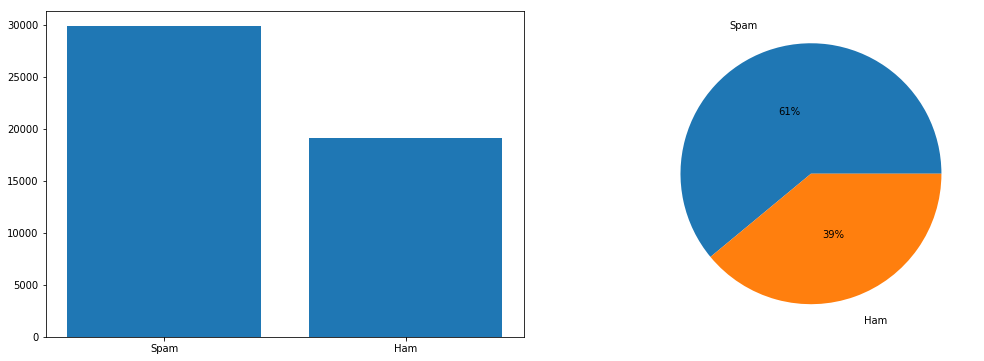

In [21]:
df = dfMaster

print(df['isSpam'].value_counts().rename({False: 'Ham', True: 'Spam'}))


fig = plt.figure(figsize = (18,6))
grid = plt.GridSpec(1,2, wspace =0.1)
barPlt = fig.add_subplot(grid[0,0])
piePlt = fig.add_subplot(grid[0,1])


barPlt.bar(
    ('Spam', 'Ham'), 
    [len(df[df['isSpam'] == True]), len(df[df['isSpam'] == False])], 
    align='center')
barPlt.set_xticks(np.arange(2), ['Spam', 'Ham'])


piePlt.pie(df['isSpam'].value_counts(), labels=['Spam', 'Ham'], autopct='%1.0f%%', pctdistance=0.5, labeldistance=1.2)


plt.show()

### Compare text lenght for ham and spam  

There is 4 differents attributes what define the text lengh:

- textLen : This is the raw text without any treatment
- treatedTextLen: This is the text after removing the stop words and ponctuation
- totalTreatedWords: This is the amount of words used in the text after the treatment, basically this exclude space and line breaks
- uniqueWordsLen: This is the amount of unique words used in the treated text, basically it removes repited words

### Raw Text size lengh comparison  

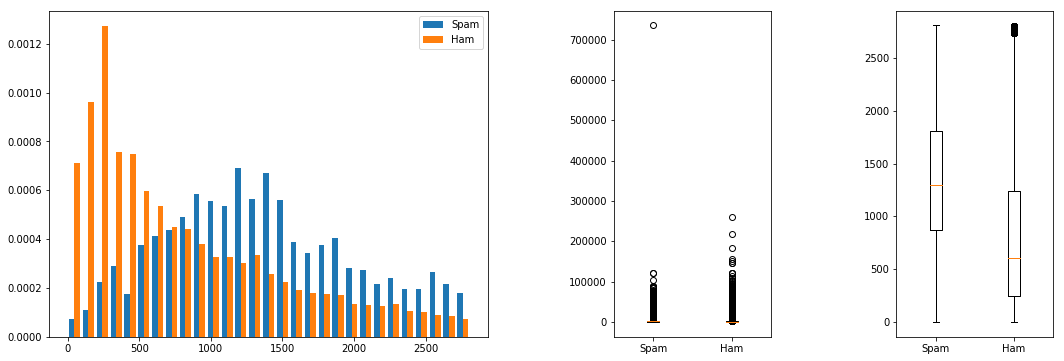

In [22]:
fig = plt.figure(figsize = (18,6))
grid = plt.GridSpec(1,4, wspace =0.8)
histPlt = fig.add_subplot(grid[0,0:2])
boxPlt1 = fig.add_subplot(grid[0,2])
boxPlt2 = fig.add_subplot(grid[0,3])

histPlt.hist(
    [
        df[df['isSpam'] == True]['textLen'], 
        df[df['isSpam'] == False]['textLen']
    ], 
    np.linspace(0, df['textLen'].quantile(0.75), 30), 
    density = True, 
    label=['Spam', 'Ham']
) 
histPlt.legend(loc='upper right')

boxPlt1.boxplot(
    (
         df[df['isSpam'] == True]['textLen'], 
         df[df['isSpam'] == False]['textLen'] 
    ), 
    labels = ('Spam', 'Ham')
)

boxPlt2.boxplot(
    (
        df[(df['isSpam'] == True) & (df['textLen'] < df['textLen'].quantile(0.75))]['textLen'], 
        df[(df['isSpam'] == False) & (df['textLen'] < df['textLen'].quantile(0.75))]['textLen'] 
    ), 
    labels = ('Spam', 'Ham')
)

plt.show()

### Text size without stop words and punctuation 

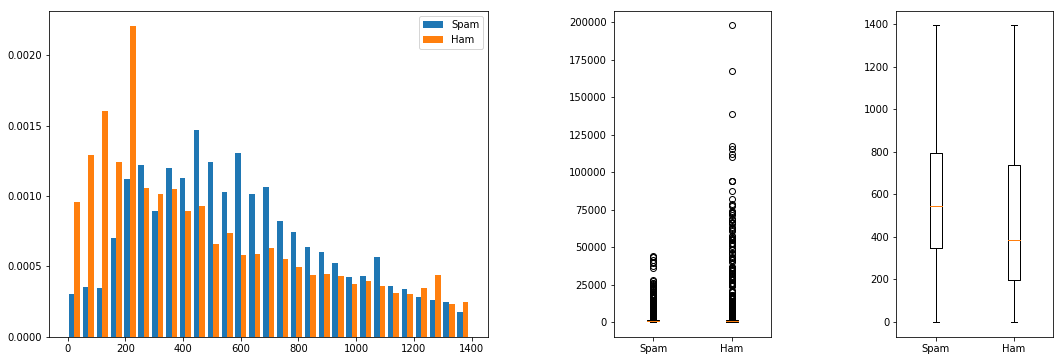

In [23]:
fig = plt.figure(figsize = (18,6))
grid = plt.GridSpec(1,4, wspace =0.8)
histPlt = fig.add_subplot(grid[0,0:2])
boxPlt1 = fig.add_subplot(grid[0,2])
boxPlt2 = fig.add_subplot(grid[0,3])

histPlt.hist(
    [
        df[df['isSpam'] == True]['treatedTextLen'], 
        df[df['isSpam'] == False]['treatedTextLen']
    ],  
    np.linspace(0, df['treatedTextLen'].quantile(0.75), 30),
    density= True,
    label=['Spam', 'Ham']
) 
histPlt.legend(loc='upper right')

boxPlt1.boxplot(
    (
        df[df['isSpam'] == True]['treatedTextLen'], 
        df[df['isSpam'] == False]['treatedTextLen'] ), 
    labels = ('Spam', 'Ham')
)

boxPlt2.boxplot(
    (
        df[(df['isSpam'] == True) & (df['treatedTextLen'] < df['treatedTextLen'].quantile(0.75))]['treatedTextLen'], 
        df[(df['isSpam'] == False) & (df['treatedTextLen'] < df['treatedTextLen'].quantile(0.75))]['treatedTextLen'] 
    ), 
    labels = ('Spam', 'Ham')
)

plt.show()



### Total words used

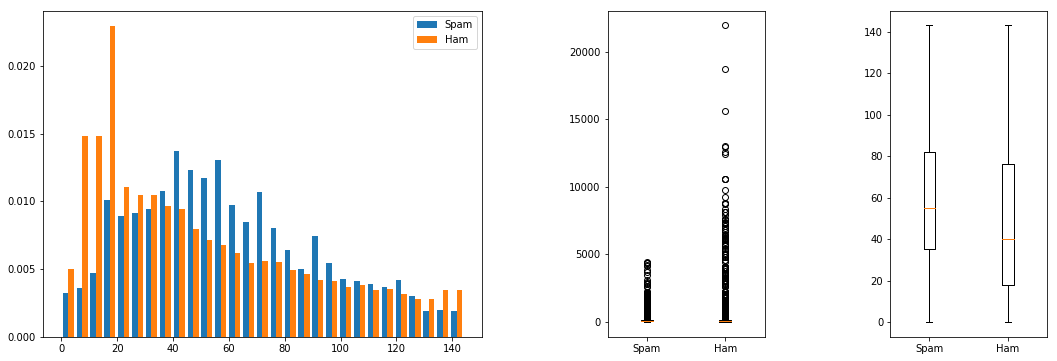

In [24]:
fig = plt.figure(figsize = (18,6))
grid = plt.GridSpec(1,4, wspace =0.8)
histPlt = fig.add_subplot(grid[0,0:2])
boxPlt1 = fig.add_subplot(grid[0,2])
boxPlt2 = fig.add_subplot(grid[0,3])

histPlt.hist(
    [
        df[df['isSpam'] == True]['totalTreatedWords'], 
        df[df['isSpam'] == False]['totalTreatedWords']
    ],  
    np.linspace(0, df['totalTreatedWords'].quantile(0.75), 30),
    density= True,
    label=['Spam', 'Ham']
) 
histPlt.legend(loc='upper right')

boxPlt1.boxplot(
    (
        df[df['isSpam'] == True]['totalTreatedWords'], 
        df[df['isSpam'] == False]['totalTreatedWords'] 
    ), 
    labels = ('Spam', 'Ham')
)

boxPlt2.boxplot(
    (
        df[(df['isSpam'] == True) & (df['totalTreatedWords'] < df['totalTreatedWords'].quantile(0.75))]['totalTreatedWords'], 
        df[(df['isSpam'] == False) & (df['totalTreatedWords'] < df['totalTreatedWords'].quantile(0.75))]['totalTreatedWords'] 
    ), 
    labels = ('Spam', 'Ham')
)

plt.show()


### Total unique words used

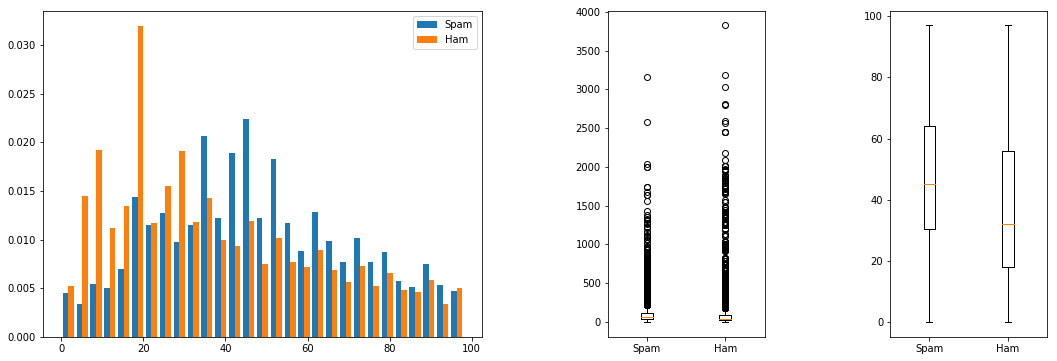

In [25]:
fig = plt.figure(figsize = (18,6))
grid = plt.GridSpec(1,4, wspace =0.8)
histPlt = fig.add_subplot(grid[0,0:2])
boxPlt1 = fig.add_subplot(grid[0,2])
boxPlt2 = fig.add_subplot(grid[0,3])

histPlt.hist(
    [
        df[df['isSpam'] == True]['uniqueWordsLen'], 
        df[df['isSpam'] == False]['uniqueWordsLen']
    ],  
    np.linspace(0, df['uniqueWordsLen'].quantile(0.75), 30),
    density= True,
    label=['Spam', 'Ham']
) 
histPlt.legend(loc='upper right')

boxPlt1.boxplot(
    (
        df[df['isSpam'] == True]['uniqueWordsLen'], 
        df[df['isSpam'] == False]['uniqueWordsLen'] 
    ), 
    labels = ('Spam', 'Ham')
)

boxPlt2.boxplot(
    (
        df[(df['isSpam'] == True) & (df['uniqueWordsLen'] < df['uniqueWordsLen'].quantile(0.75))]['uniqueWordsLen'], 
        df[(df['isSpam'] == False) & (df['uniqueWordsLen'] < df['uniqueWordsLen'].quantile(0.75))]['uniqueWordsLen'] 
    ), 
    labels = ('Spam', 'Ham')
)

plt.show()


### Conclusion

# Need to do 

----It's not clear the text size can influence into the classification of the email in spam or ham.



## Words Visualization

### Total uniques words

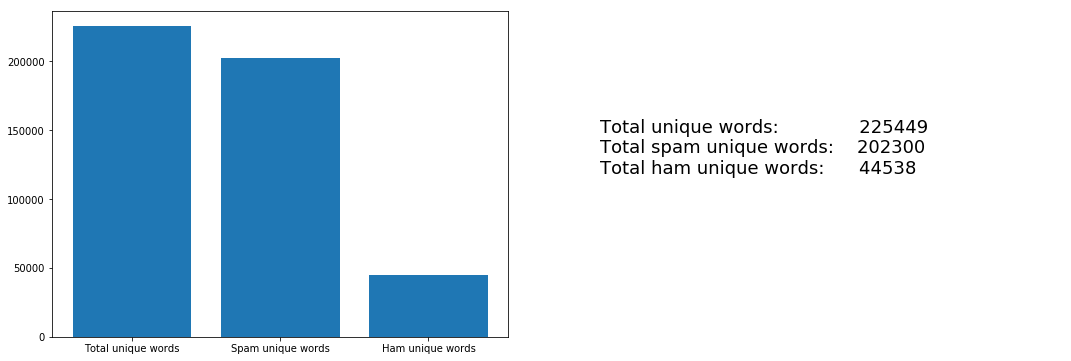

In [26]:
count = Counter(list(chain(*df["wordsList"].values)))

countSpam = Counter(list(chain(*df[df['isSpam'] == True]["wordsList"].values)))

countHam = Counter(list(chain(*df[df['isSpam'] == False]["wordsList"].values)))

fig = plt.figure(figsize = (18,6))
grid = plt.GridSpec(1,2, wspace =0.2)
pltBar = fig.add_subplot(grid[0,0])
pltText = fig.add_subplot(grid[0,1])


pltBar.bar(
    ['Total unique words', 'Spam unique words', 'Ham unique words'], 
    [len(count), len(countSpam), len(countHam)], 
    align='center'
)

textWords = ['Total unique words:              {}'.format(len(count)), 
             'Total spam unique words:    {}'.format(len(countSpam)), 
             'Total ham unique words:      {}'.format(len(countHam))]


pltText.text(x=0, y=0.5, s = '\n'.join(textWords), fontsize = 18) 
pltText.axis('off')
plt.show()

In [27]:
count.most_common(100)

[('company', 44338),
 ('com', 43622),
 ('ect', 39565),
 ('quot', 34735),
 ('subject', 33362),
 ('gt', 27685),
 ('priority', 26855),
 ('price', 26472),
 ('lt', 26111),
 ('date', 24034),
 ('http', 23291),
 ('time', 23157),
 ('market', 22970),
 ('business', 22070),
 ('new', 21318),
 ('information', 21067),
 ('message', 20981),
 ('say', 20513),
 ('hou', 19245),
 ('version', 18294),
 ('mail', 17858),
 ('statement', 17482),
 ('email', 17014),
 ('need', 16558),
 ('send', 16536),
 ('report', 16521),
 ('microsoft', 16450),
 ('year', 16431),
 ('service', 16428),
 ('stock', 16278),
 ('day', 15998),
 ('mime', 15811),
 ('forward', 15765),
 ('normal', 15693),
 ('look', 15659),
 ('gas', 15657),
 ('use', 15560),
 ('produce', 15181),
 ('www', 14864),
 ('security', 14832),
 ('thank', 14817),
 ('trade', 14781),
 ('know', 14548),
 ('make', 14036),
 ('energy', 14029),
 ('work', 13359),
 ('font', 13184),
 ('include', 13172),
 ('deal', 12856),
 ('msmail', 12794),
 ('receive', 12479),
 ('product', 12473),
 ('

### 20 Most common words

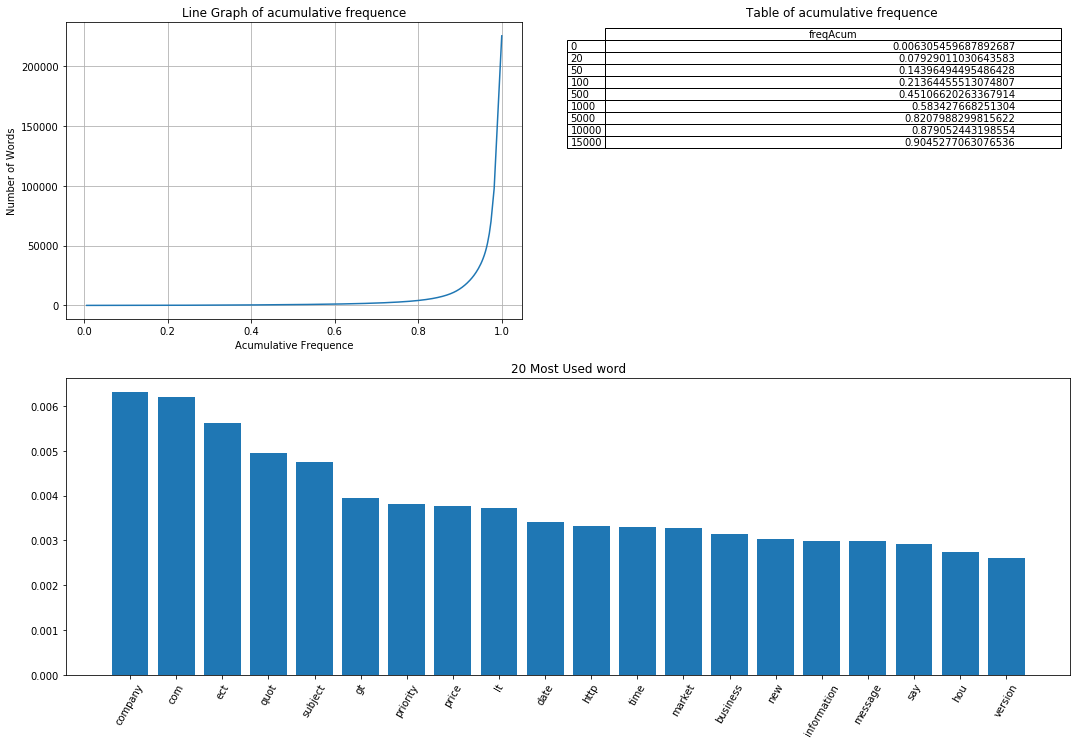

In [28]:
dfWords = pd.DataFrame(list(dict(count).items()))
dfWords.columns = ['word', 'occur'] 
totalOcurr = dfWords['occur'].sum()
dfWords['freq'] = dfWords['occur'] / totalOcurr  
dfWords = dfWords.sort_values(by='freq', ascending=False)
dfWords = dfWords.reset_index(drop=True)
dfWords['freqAcum'] = dfWords['freq'].cumsum()


fig = plt.figure(figsize = (18,12))
grid = plt.GridSpec(4,2, wspace =0.2, hspace = 0.5)
pltLine = fig.add_subplot(grid[0:2,0])
pltBar = fig.add_subplot(grid[2:4,0:2])
pltTable = fig.add_subplot(grid[0:2,1])

pltLine.plot(dfWords['freqAcum'], range(len(dfWords)))
pltLine.set_ylabel('Number of Words')
pltLine.set_xlabel('Acumulative Frequence')
pltLine.set_title('Line Graph of acumulative frequence')
pltLine.grid(True)


dfTWord = dfWords.loc[[0,20,50,100,500,1000,5000,10000,15000]][['freqAcum']]

pltTable.table(cellText=dfTWord.values, rowLabels= dfTWord.index, colLabels = dfTWord.columns, loc='best')
pltTable.axis('off')
pltTable.set_title('Table of acumulative frequence')



pltBar.bar(dfWords.head(20)['word'], dfWords.head(20)['freq'])
pltBar.set_title('20 Most Used word')

yPos = np.arange(20)
pltBar.set_xticklabels(dfWords.head(20)["word"], rotation=60)
pltBar.set_xticks(yPos)


plt.show()



### 20 Most common words on Spam emails

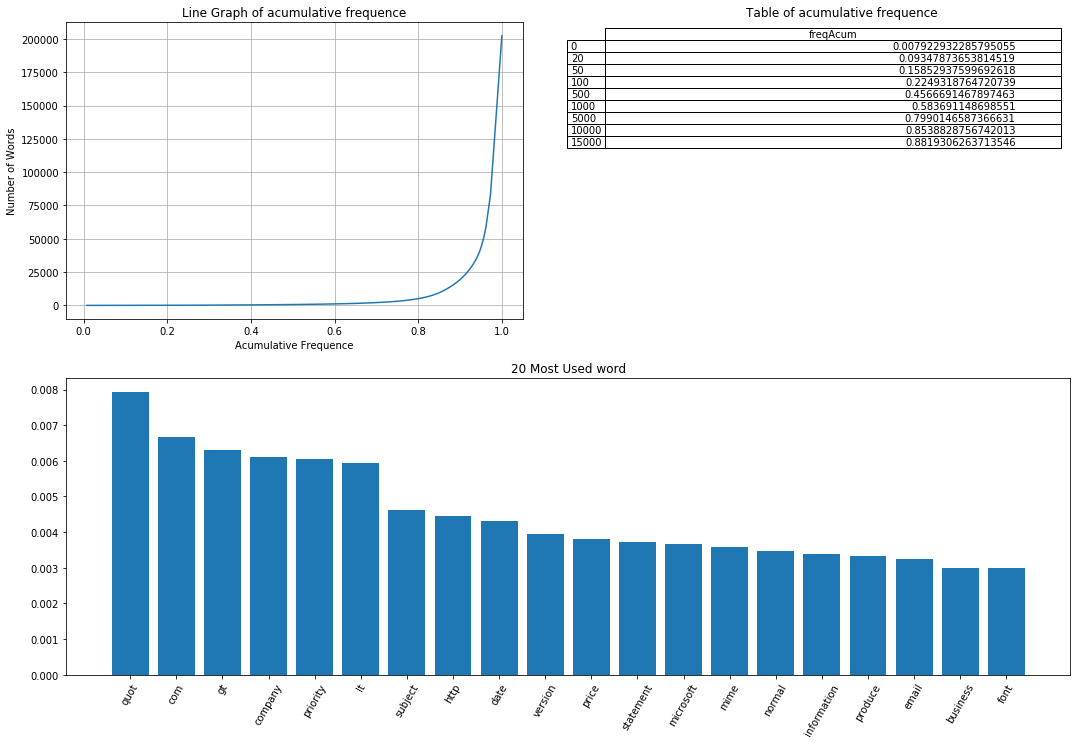

In [29]:
dfSpamWords = pd.DataFrame(list(dict(countSpam).items()))
dfSpamWords.columns = ['word', 'occur'] 
totalSpamOcurr = dfSpamWords['occur'].sum()
dfSpamWords['freq'] = dfSpamWords['occur'] / totalSpamOcurr  
dfSpamWords = dfSpamWords.sort_values(by='freq', ascending=False)
dfSpamWords = dfSpamWords.reset_index(drop=True)
dfSpamWords['freqAcum'] = dfSpamWords['freq'].cumsum()


fig = plt.figure(figsize = (18,12))
grid = plt.GridSpec(4,2, wspace =0.2, hspace = 0.5)
pltLine = fig.add_subplot(grid[0:2,0])
pltBar = fig.add_subplot(grid[2:4,0:2])
pltTable = fig.add_subplot(grid[0:2,1])

pltLine.plot(dfSpamWords['freqAcum'], range(len(dfSpamWords)))
pltLine.set_ylabel('Number of Words')
pltLine.set_xlabel('Acumulative Frequence')
pltLine.set_title('Line Graph of acumulative frequence')
pltLine.grid(True)


dfSWord = dfSpamWords.loc[[0,20,50,100,500,1000,5000,10000,15000]][['freqAcum']]

pltTable.table(cellText=dfSWord.values, rowLabels= dfSWord.index, colLabels = dfSWord.columns, loc='best')
pltTable.axis('off')
pltTable.set_title('Table of acumulative frequence')



pltBar.bar(dfSpamWords.head(20)['word'], dfSpamWords.head(20)['freq'], align='center')
pltBar.set_title('20 Most Used word')

yPos = np.arange(20)
pltBar.set_xticklabels(dfSpamWords.head(20)["word"], rotation=60)
pltBar.set_xticks(yPos)

plt.show()



### 20 Most common words on Ham emails

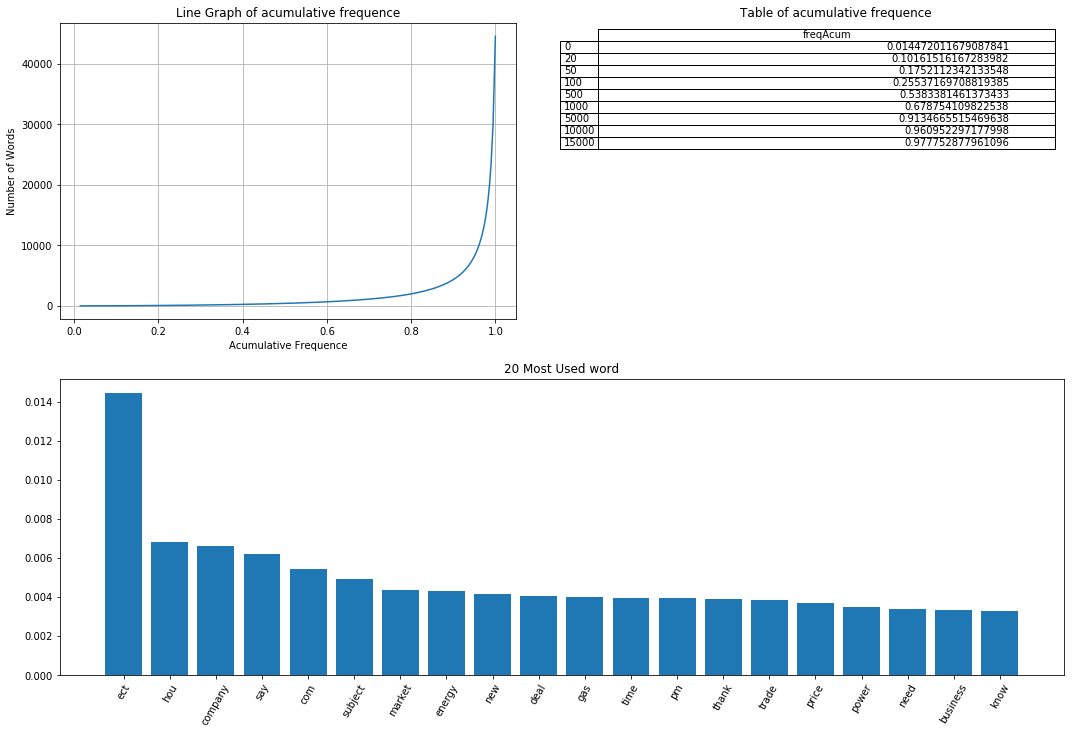

In [30]:
dfHamWords = pd.DataFrame(list(dict(countHam).items()))
dfHamWords.columns = ['word', 'occur'] 
totalHamOcurr = dfHamWords['occur'].sum()
dfHamWords['freq'] = dfHamWords['occur'] / totalHamOcurr  
dfHamWords = dfHamWords.sort_values(by='freq', ascending=False)
dfHamWords = dfHamWords.reset_index(drop=True)
dfHamWords['freqAcum'] = dfHamWords['freq'].cumsum()


fig = plt.figure(figsize = (18,12))
grid = plt.GridSpec(4,2, wspace =0.2, hspace = 0.5)
pltLine = fig.add_subplot(grid[0:2,0])
pltBar = fig.add_subplot(grid[2:4,0:2])
pltTable = fig.add_subplot(grid[0:2,1])

pltLine.plot(dfHamWords['freqAcum'], range(len(dfHamWords)))
pltLine.set_ylabel('Number of Words')
pltLine.set_xlabel('Acumulative Frequence')
pltLine.set_title('Line Graph of acumulative frequence')
pltLine.grid(True)


dfHWord = dfHamWords.loc[[0,20,50,100,500,1000,5000,10000,15000]][['freqAcum']]

pltTable.table(cellText=dfHWord.values, rowLabels= dfHWord.index, colLabels = dfHWord.columns, loc='best')
pltTable.axis('off')
pltTable.set_title('Table of acumulative frequence')



pltBar.bar(dfHamWords.head(20)['word'], dfHamWords.head(20)['freq'], align='center')
pltBar.set_title('20 Most Used word')

yPos = np.arange(20)
pltBar.set_xticklabels(dfHamWords.head(20)["word"], rotation=60)
pltBar.set_xticks(yPos)

plt.show()



#### Word List

In [ ]:
tempStr = 'a b c44 66d e5e '

clean = re.compile('[0-9]')
tex = re.sub(clean, " ", tempStr)

print(tex)



In [ ]:
tempSet = sorted(set(list(chain(*df[df['isSpam'] == True]["wordsList"].values))))


print(tempSet)

In [ ]:
from spellchecker import SpellChecker

spell = SpellChecker()

# find those words that may be misspelled
misspelled = spell.unknown(tempSet)

print(misspelled)

In [ ]:
lem = WordNetLemmatizer()
words = lem.lemmatize('accommodations')

words

## Modeling

### Spliting prepare data set for modeling 

In [ ]:
#print(text.ENGLISH_STOP_WORDS)

print(type(text.ENGLISH_STOP_WORDS))



In [ ]:
l = list(chain(*df["wordsList"].values))

l = set(filter(lambda k : len(k) == 1, l))

l

In [ ]:
dfWordsG = pd.DataFrame(list(dict(count).items()))
dfWordsG.columns = ['word', 'occur'] 
totalOcurrG = dfWordsG['occur'].sum()
dfWordsG['freq'] = dfWordsG['occur'] / totalOcurrG  
dfWordsG = dfWordsG.sort_values(by='freq', ascending=False)
dfWordsG = dfWordsG.reset_index(drop=True)
dfWordsG['freqAcum'] = dfWordsG['freq'].cumsum()

dfSpamWordsG = pd.DataFrame(list(dict(countSpam).items()))
dfSpamWordsG.columns = ['word', 'occur'] 
totalSpamOcurrG = dfSpamWordsG['occur'].sum()
dfSpamWordsG['freq'] = dfSpamWordsG['occur'] / totalOcurrG  
dfSpamWordsG = dfSpamWordsG.sort_values(by='freq', ascending=False)
dfSpamWordsG = dfSpamWordsG.reset_index(drop=True)
dfSpamWordsG['freqAcum'] = dfSpamWordsG['freq'].cumsum()

dfHamWordsG = pd.DataFrame(list(dict(countHam).items()))
dfHamWordsG.columns = ['word', 'occur'] 
totalHamOcurrG = dfHamWordsG['occur'].sum()
dfHamWordsG['freq'] = dfHamWordsG['occur'] / totalOcurrG  
dfHamWordsG = dfHamWordsG.sort_values(by='freq', ascending=False)
dfHamWordsG = dfHamWordsG.reset_index(drop=True)
dfHamWordsG['freqAcum'] = dfHamWordsG['freq'].cumsum()

fig = plt.figure(figsize = (18,6))
grid = plt.GridSpec(1,3, wspace =0.2)
pltTotal = fig.add_subplot(grid[0,0])
pltSpam = fig.add_subplot(grid[0,1])
pltHam = fig.add_subplot(grid[0,2])

pltTotal.plot(dfWords['freqAcum'], range(len(dfWordsG)))
pltTotal.set_ylabel('Total Words')
pltTotal.set_xlabel('Acumulative Frequence')
pltTotal.set_title('All Words')
pltTotal.grid(True)

pltSpam.plot(dfSpamWords['freqAcum'], range(len(dfSpamWordsG)))
pltSpam.set_ylabel('Total Spam Words')
pltSpam.set_xlabel('Acumulative Frequence')
pltSpam.set_title('Spam Words')
pltSpam.grid(True)

pltHam.plot(dfHamWords['freqAcum'], range(len(dfHamWordsG)))
pltHam.set_ylabel('Total Ham Words')
pltHam.set_xlabel('Acumulative Frequence')
pltHam.set_title('Ham Words')
pltHam.grid(True)


fig2 = plt.figure(figsize = (18,6))
grid2 = plt.GridSpec(1,6, wspace =0.4)

pltTotalTableG = fig2.add_subplot(grid2[0,0:2])
pltSpamTableG = fig2.add_subplot(grid2[0,2:4])
pltHamTableG = fig2.add_subplot(grid2[0,4:6])

dfTWordG = dfWordsG.loc[[0,50,100,500,1000,5000,10000,15000]][['freqAcum']]

pltTotalTableG.table(cellText=dfTWordG.values, rowLabels= dfTWordG.index, colLabels = dfTWordG.columns, loc='best')
pltTotalTableG.axis('off')

dfSWordG = dfSpamWordsG.loc[[0,50,100,500,1000,5000,10000,15000]][['freqAcum']]

pltSpamTableG.table(cellText=dfSWordG.values, rowLabels= dfSWordG.index, colLabels = dfSWordG.columns, loc='best')
pltSpamTableG.axis('off')

dfHWordG = dfHamWordsG.loc[[0,50,100,500,1000,5000,10000,15000]][['freqAcum']]

pltHamTableG.table(cellText=dfHWordG.values, rowLabels= dfHWordG.index, colLabels = dfHWordG.columns, loc='best')
pltHamTableG.axis('off')


plt.show()


In [ ]:
patternStop = re.compile(r'\b(' + r'|'.join(text.ENGLISH_STOP_WORDS) + r')\b\s*')
text = patternStop.sub(' ', text)



In [ ]:
t


In [ ]:
txt.ENGLISH_STOP_WORDS